# The naïve Bayes classifier

Max Collard, May 2021

## 4. All models are wrong; some are useful

### Modeling the data

The problem with the "perfect" Bayes classifier is that in most cases, especially in biology, there is **no way to know the truth about how the data are generated**; that is, we can never *truly know* the probabilities

$$
\begin{eqnarray*}
&& \mathrm{Pr}(\mathcal{D} \mid \textrm{direction} = \textrm{Left}) \\
&& \mathrm{Pr}(\mathcal{D} \mid \textrm{direction} = \textrm{Right})
\end{eqnarray*}
$$

This knowledge was **explicitly necessary** to make the "optimal" Bayes classifier; so, in general, the Bayes classifier is **impossible to obtain**.

Instead, we will have to satisfy ourselves with coming up with some kind of **imperfect model** for how *we think* the data were generated; let's call the probabilities in this model

$$
\begin{eqnarray*}
&& \mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Left}) \\
&& \mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Right})
\end{eqnarray*}
$$

Thinking of $\mathrm{Pr}$ as a "perfect ruler" that measures the "size" of the part of the multiverse we observed that we live in, we can think of $\mathcal{M}$ as being a **really badly manufactured ruler**: it won't get us the exact right answer, but as long as it isn't *too bad*, we can still draw some conclusions from the measurements we get from it.

A perfect ruler (the standard meter [from NIST](https://www.nist.gov/si-redefinition/meter#:~:text=Building%20upon%20these%20and%20other,per%20second%20in%20a%20vacuum.)):

<img src="images/4/nist-library-us-prototype-meter-bar-color_hr_1.jpg" />

What we use in science:

<img src="images/4/vintage+wooden+school+rulers+1.jpg" />

### The Poisson process: The default model for neuronal firing

It's 8:05am. You've got class at 9. The last shuttle that will get you there on time leaves at 8:20. You do your best to get ready, get out the door, and bolt to the bus stop, but you live in the part of the multiverse where you arrived at 8:24, so you're out of luck. But the bus comes on a schedule that you know runs every 15 minutes; since it's 8:24, four minutes late, you *know* that another bus will be there in 11 minutes, at 8:35. Put in Bayesian terms, *given the knowledge* that you are 4 minutes late, you *believe* that the bus will arrive in 11 minutes. Not great, but you will probably be forgiven.

There is, however, another world—a dark and scary world—called **Poisson** land. In Poisson land, everything is *reliable on average*, but nothing is *predictable*. What do I mean by this? Well, let's say you got to the bus stop at 8:24, and the last bus left at 8:20, just like in the first scenario. In Poisson land, you know that *on average*, in all possible worlds, the bus will get there 15 minutes after 8:20. But this is where the similarities end. In Poisson land, **knowing that the bus left 4 minutes ago tells you nothing about when the next bus will be there**; that is, the bus' arrival time is **independent of when the last bus arrived**. The next bus might be there in five seconds; it might be there in five years. But here's the weird part about Poisson land: now that it's 8:24, *on average*, the next bus will still come *in 15 minutes*, at 8:39. Even if you knew you had been waiting at the stop for 20 years without a bus coming, your *belief* about when the next bus would come would still be the same—*15 more minutes*.

This is the primary property of the **Poisson process** as a model of when "events" (like bus arrivals, or neuronal action potentials) occur: event occurrences are **independent of the history of previous events**. In fact, the only thing that the events *actually do* depend on is the **average rate of events happening**—in the above example, one bus per 15 minutes.

This model is completely absurd—we don't live in a world that behaves anything like Poisson land. However, it is an extremely **useful** model because it is *so unrestrictive* about the way in which events happen. In the context of spiking neurons, the model *only* makes the assumption that the neuron fires at a particular rate, say 15 times per second. In a certain sense, the events are placed "*as randomly as possible*" under the assumption that the neuron has to fire 15 times per second.

---

Let's think back to our T maze example: again, the mouse goes left or right, and we record the number of spikes that happen in five hippocampal neurons before the mouse makes that choice. Let's say that this mouse is *extremely* well-trained, and every single trial, it takes *exactly the same amount of time* to make its choice, say, 10 seconds. Let's think about what would happen if neuron 1 lived in "Poisson land", with spikes happening "totally randomly" at a rate of 10 spikes per second. In this case, because of the math of Poisson land, over many trials, the number of spikes produced by neuron 1 inside of that 10 second window would follow a **Poisson distribution** (hence the name "Poisson process"). In this case, the *average number of spikes* we would expect from neuron 1 would be its spike rate, 10 spikes per second, *times* the amount of time we observed the neuron for, 10 seconds: this is

$$ 10 \frac{\textrm{spikes}}{\textrm{second}} \times 10 \textrm{ seconds} = 100 \textrm{ spikes} $$

There is, though, some variability: in some trials, the neuron might fire 80 spikes; in others, it might fire 120. We can use `scipy` to show us what this distribution looks like:

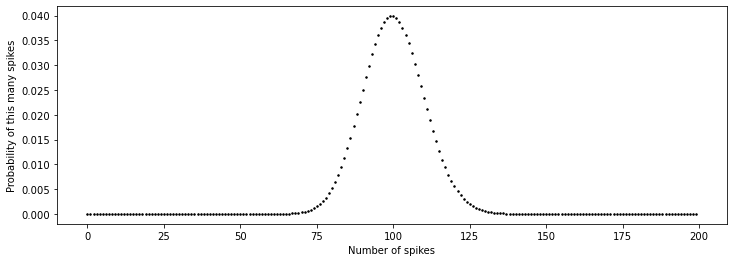

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

spikes_per_sec = 10
trial_length = 10
average_spikes = spikes_per_sec * trial_length

n_spikes_test = np.arange( 0, 200 )
# pmf means "probability mass function"
p_test = stats.poisson.pmf( n_spikes_test, average_spikes )

plt.figure( figsize = (12, 4) )

plt.plot( n_spikes_test, p_test, 'k.', markersize = 3 )

plt.ylabel( 'Probability of this many spikes' )
plt.xlabel( 'Number of spikes' )

plt.show()

So, this neuron will *almost always* fire between 75 and 125 action potentials over the course of the trial.

I guess that's kind of interesting. But we're interested in figuring out *which direction the mouse goes*; and as we saw, for us to be able to solve this problem, we need the neuron to **fire differently between the two directions**. So, a much more interesting model would be if the neuron "prefers" going to the left over going to the right. As an example, let's see what happens if the neuron fires *12 spikes per second* going to the left, but *8 spikes per second* going to the right.

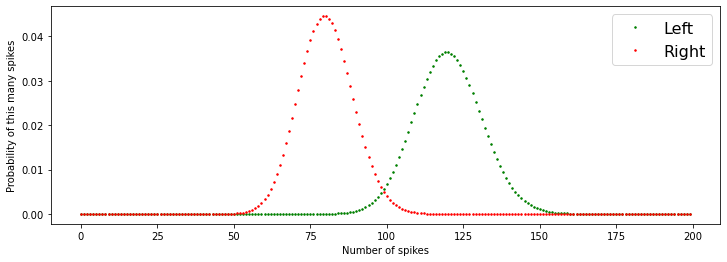

In [14]:
spikes_per_sec_left = 12
spikes_per_sec_right = 8

trial_length = 10
average_spikes_left = spikes_per_sec_left * trial_length
average_spikes_right = spikes_per_sec_right * trial_length

n_spikes_test = np.arange( 0, 200 )
p_test_left = stats.poisson.pmf( n_spikes_test,
                                 average_spikes_left )
p_test_right = stats.poisson.pmf( n_spikes_test,
                                  average_spikes_right )

plt.figure( figsize = (12, 4) )

plt.plot( n_spikes_test,
          p_test_left,
          'g.',
          markersize = 3,
          label = 'Left' )
plt.plot( n_spikes_test,
          p_test_right,
          'r.',
          markersize = 3,
          label = 'Right' )

plt.ylabel( 'Probability of this many spikes' )
plt.xlabel( 'Number of spikes' )

plt.legend( fontsize = 16 )

plt.show()

There's still a lot of variability here; *but*, we can start to see how this neuron might be able to give us knowledge about which direction the mouse decided to go. As an example, let's say that we actually recorded 125 spikes from this neuron. The probability of this neuron firing 125 times on a $\textrm{Right}$ trial is **almost zero**; but, there's a pretty decent chance of this neuron firing 125 times on a $\textrm{Left}$ trial. Intuitively, seeing this many spikes from this neuron *tells us* that this was probably a left trial.

This model allows us to **assign "estimated" probabilities** to the data (spike counts in each neuron) that we observe in each direction:

$$
\begin{eqnarray*}
&& \mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Left}) \\
&& \mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Right})
\end{eqnarray*}
$$

> Notice, though, that this model **does not care at all about spike timing**: all it cares about is the *number of spikes* that happened in a given period of time. Spike timing probably matters *in reality* (for the "*true*" *ruler*, $\mathrm{Pr}$); but it is completely ignored *by the model* we are choosing to use to make our predictions (for the "*bad*" *ruler*, $\mathcal{M}$).

With this in hand, we can now plug these "bad rulers" into the formula for our Bayes classifier to come up with an "estimate" for how likely each direction is based on our data:

$$
\begin{eqnarray*}
\mathrm{Pr}(\textrm{direction} = \textrm{Left} \mid \mathcal{D}) & = & \mathrm{Pr}(\textrm{direction} = \textrm{Left})\,\frac{\mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Left})}{\mathrm{Pr}(\mathcal{D})} \\
\mathrm{Pr}(\textrm{direction} = \textrm{Right} \mid \mathcal{D}) & = & \mathrm{Pr}(\textrm{direction} = \textrm{Right})\,\frac{\mathcal{M}(\mathcal{D} \mid \textrm{direction} = \textrm{Right})}{\mathrm{Pr}(\mathcal{D})} \\
\end{eqnarray*}
$$

Let's see how we can do with this "estimated" Bayes classifier from the setup above: a single neuron that fires at a higher rate going to the left, and a lower rate going to the right. We'll try varying the difference between these two rates, to see how it impacts our decoding performance

In [15]:
spikes_per_sec_center = 10

# How many simulations we will run for each difference
n_sims = 2000

# Our prior expectation - it looks like the mouse tends to go
# to the left a little more. We'll assume that this expectation
# is *accurate*
prior_left = 0.6
prior_right = 1. - prior_left # "The rest of the time"

# The difference between the left and right spike rate we want to test
spikes_per_sec_diff_test = np.arange( 0, 9.1, 0.5 )

n_correct_test = np.zeros( spikes_per_sec_diff_test.shape )

for i_diff in range( spikes_per_sec_diff_test.shape[0] ):
    
    cur_diff = spikes_per_sec_diff_test[i_diff]
    
    spikes_per_sec_left = spikes_per_sec_center + (cur_diff / 2.)
    spikes_per_sec_right = spikes_per_sec_center - (cur_diff / 2.)
    
    for i_sim in range( n_sims ):
        ## First let's pick which direction the mouse went

        # Pick a random number between 0 and 1
        r = np.random.uniform( low = 0., high = 1. )
        if r < prior_left:
            # For example, if prior_left = 0.6, this happens 60% of the time
            cur_dir = 'left'
        else:
            # This happens "the rest of the time"
            cur_dir = 'right'

        ## Next, let's simulate how many spikes happened
        if cur_dir == 'left':
            n_spikes = stats.poisson.rvs( spikes_per_sec_left )
        if cur_dir == 'right':
            n_spikes = stats.poisson.rvs( spikes_per_sec_right )

        ## Finally, let's use Bayes' rule based on this data to pick
        # the "best" choice
        updated_left = prior_left * stats.poisson.pmf( n_spikes, spikes_per_sec_left )
        updated_right = prior_right * stats.poisson.pmf( n_spikes, spikes_per_sec_right )

        if updated_left > updated_right:
            cur_choice = 'left'
        if updated_right > updated_left:
            cur_choice = 'right'
        else:
            # Technically, we have to break ties;
            # I'm going to do it by just choosing left
            # This is *very unlikely* to happen, and so won't really
            # affect anything
            cur_choice = 'left'

        ## Let's see how we did!
        if cur_choice == cur_dir:
            # We got it right!
            n_correct_test[i_diff] += 1

# Turn the number correct into a *fraction* correct
frac_correct_test = n_correct_test / n_sims

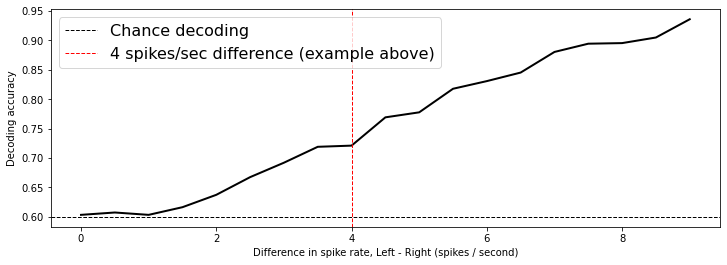

In [19]:
## Plot the results

plt.figure( figsize = (12, 4) )

plt.plot( spikes_per_sec_diff_test,
          frac_correct_test,
          'k-',
          linewidth = 2)

# Show the chance level, which is the larger of the two priors
frac_correct_chance = np.maximum( prior_left, prior_right )
xl = plt.xlim()
plt.plot( xl,
          [frac_correct_chance, frac_correct_chance],
          'k--',
          linewidth = 1,
          label = 'Chance decoding' )
plt.xlim( xl )

# Show the difference we used for the example
yl = plt.ylim()
plt.plot( [4., 4.],
          yl,
          'r--',
          linewidth = 1,
          label = '4 spikes/sec difference (example above)' )
plt.ylim( yl )

plt.xlabel( 'Difference in spike rate, Left - Right (spikes / second)' )
plt.ylabel( 'Decoding accuracy' )

plt.legend( fontsize = 16 )

plt.show()

So even recording from just a **single neuron**, with a difference as small as 12 spikes/second to the left versus 8 spikes/second to the right, we can decode substantially above chance ($\sim$ 72% in this case). Neat!

### Dependence and the curse of dimensionality

This is a perfectly usable classifier for a single neuron! But if we want to think about *multiple neurons* —which, yeah, of course we do—we run into one more problem. Neurons are **interconnected**: the firing of a single neuron is **dependent** on the firing of many, many other neurons (maybe even *all of them*; 〜ｓｐｏｏｋｙ〜). To intuitively understand the big issue with this, we need to build one more tool.

A mathematical **graph** is a set of points called **vertices** with a bunch of lines connecting them, called **edges**. Here's a graph:

<img src="images/4/IMG_0138.PNG" />

Random variables can either be **independent** or **dependent** (that is, *not independent*). If we have a bunch of random variables, we can make a graph out of them, by making each *random variable* into a *vertex*, and placing an edge between two random variables if they are *dependent*. So, for example, for the classification problem above, we have two random variables $\textrm{direction}$, the thing we're trying to decide, and $N$, the number of spikes in the neuron we recorded. These two are connected, because they are dependent (if they weren't, then there would be "two identical pictures", and so classification would be impossible).

<img src="images/4/IMG_0139.PNG" />

Dependencies are important because **each one needs to be modeled**. For example, in the problem above, because $N$ and $\textrm{direction}$ are dependent, we had to come up with a model that describes how they are related.

This begins to get complicated as we start adding more neurons. Because neurons are interconnected, and so *dependent*, as we add more neurons into the model we're building, we have to add **more edges** (*dependencies*) between them. For example, with three neurons, $N_1, N_2, N_3$, we would have:

<img src="images/4/IMG_0143.PNG" />

That's definitely more complicated. The situation **gets worse very quickly** as we add more neurons:

<img src="images/4/IMG_0144.PNG" />

Even with only 5 neurons, we already have **15 conditional dependencies** we have to model!

**The curse of dimensionality** is used with a lot of different meanings, but this is one of them: if you're building a model involving a large number of random variables, *the number of conditional dependencies explodes*. In order to build a model that is actually tractable, we need to find a way to simplify the network structure.